# Data Exploitation: Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering

This notebook is devoted to experimenting with the implementation of Convolutional Neural Networks (CNNs) translated onto the problem of a word embedding graph. The libraries, methods, and techniques presented here utilize the work introduced in the paper: Michaël Defferrard, Xavier Bresson, Pierre Vandergheynst, [Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering](https://arxiv.org/abs/1606.09375), Neural Information Processing Systems (NIPS), 2016.

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from collections import Counter
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, feature_extraction, model_selection
import scipy
from scipy import spatial, sparse
import scipy.sparse.linalg

from lib import models, graph, coarsening, utils
%matplotlib inline

# Data extraction

In order to extract the elements necessary for forming the CNNs, we re-use data obtained during the implementation of previous steps, such as data created in the data exploration phase.

To build the graph that will be used in this notebook, we must first create a dataset containing the movies, their genres and the keywords used to describe each of these movies.

In [ ]:
first_genres = pd.read_csv('../project/data/first_genres_largest.csv')
first_genres.drop(columns = 'Unnamed: 0', inplace = True)
features_df = pd.read_csv('../project/data/refined_features.csv')
features_df.drop(columns = ['Unnamed: 0'], inplace = True)
features_df = features_df[['movie_id', 'keywords']]
movies_df = first_genres.join(features_df)
movies_df['first_genre'] = movies_df.first_genre.astype('category')
movies_df['first_genre_codes'] = movies_df['first_genre'].cat.codes
movies_df.head()


Next, we divide this data into a *training* and a *testing* set, taking care to make sure that our subsampling is stratified. It is important that all categories (in our case movie genres) are equally represented in the sampled data, as this ensures that future results are not biased. 

In [ ]:
train_data, test_data = model_selection.train_test_split(movies_df, test_size = 0.4, stratify=movies_df['first_genre'])
print('Training size: {}, Testing size: {}'.format(len(train_data), len(test_data)))
train_data.head(5)

## Training data

In order to implement the CNN, the *training* data must be preprocessed. In this section of the notebook we store our *training* data in a *Keywords* structure (the *Keywords* class extends the *TextDataset* class, implemented in the *utils* module).

The *training* data is then pre-processed and prepared for use in the CNN; all characters are transformed to lower case letters and whitespaces, stopwords commonly found in the English language are removed and the movie-keywords are transformed to bags-of-words.

Later, short 'documents' with less than 5 words are removed, and from the remaining words, the ones which have embedding are retained. Since there is not a large number of words at this point, we chose to keep all of them, and not filter any further.

Finally, the *training* data is normalized, using the $l_1$ norm.

In [ ]:
train_keywords = utils.Keywords(dataset = train_data, categories = list(movies_df['first_genre'].cat.categories))
train_keywords.clean_text(num='substitute')
train_keywords.vectorize(stop_words='english')
train_keywords.data_info()

In [ ]:
train_keywords.show_document(1);

In [ ]:
train_keywords.data_info(True)
wc = train_keywords.remove_short_documents(nwords=5, vocab='full')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
train_keywords.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [ ]:
train_keywords.embed()
train_keywords.data_info()

In [ ]:
freq = train_keywords.keep_top_words(1000, 20)
train_keywords.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(freq);

In [9]:
# Remove documents whose signal would be the zero vector.
wc = train_keywords.remove_short_documents(nwords=5, vocab='selected')
train_keywords.data_info(True)

N = 912 documents, M = 793 words, sparsity=1.3213%
    184 documents in class  0 (Action)
    101 documents in class  1 (Adventure)
     31 documents in class  2 (Animation)
    154 documents in class  3 (Comedy)
     49 documents in class  4 (Crime)
      4 documents in class  5 (Documentary)
    172 documents in class  6 (Drama)
     12 documents in class  7 (Family)
     36 documents in class  8 (Fantasy)
      5 documents in class  9 (History)
     49 documents in class 10 (Horror)
      2 documents in class 11 (Music)
     11 documents in class 12 (Mystery)
     22 documents in class 13 (Romance)
     30 documents in class 14 (Science Fiction)
     41 documents in class 15 (Thriller)
      5 documents in class 16 (War)
      4 documents in class 17 (Western)


In [10]:
train_keywords.normalize(norm='l1')

## Testing data

We pre-process the *testing* data in a similar way as we did the *training* data. First, it's stored in a *Keywords* structure, after which all characters are transformed to lower case letters and whitespaces.  Only words which occur in the *training* data vocabulary are retained. The *testing* data is also normalized using the $l_1$ norm.

In [11]:
test_keywords = utils.Keywords(dataset = test_data, categories = list(movies_df['first_genre'].cat.categories))
test_keywords.clean_text(num='substitute')
test_keywords.vectorize(vocabulary=train_keywords.vocab)
test_keywords.data_info()
wc = test_keywords.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test_keywords.data_info(True)
test_keywords.normalize(norm='l1')

N = 777 documents, C = 18 classes
N = 777 documents, M = 793 words, sparsity=1.0216%
shortest: 0, longest: 98 words
N = 593 documents, M = 793 words, sparsity=1.2357%
    122 documents in class  0 (Action)
     64 documents in class  1 (Adventure)
     21 documents in class  2 (Animation)
    107 documents in class  3 (Comedy)
     22 documents in class  4 (Crime)
      1 documents in class  5 (Documentary)
    110 documents in class  6 (Drama)
      6 documents in class  7 (Family)
     22 documents in class  8 (Fantasy)
      3 documents in class  9 (History)
     38 documents in class 10 (Horror)
      1 documents in class 11 (Music)
      8 documents in class 12 (Mystery)
     12 documents in class 13 (Romance)
     21 documents in class 14 (Science Fiction)
     30 documents in class 15 (Thriller)
      4 documents in class 16 (War)
      1 documents in class 17 (Western)


# Feature graph creation

The following step is the creation of the feature graph. We convert the *training* and *testing* datasets into the required data type, and then proceed to create the *graph_data* based on the embeddings of all of the words in our *training* dataset (these same words are used also in the *testing* dataset). We then calculate the cosine distance between each pair of words and keep only those that are most strongly connected as neighbors in the graph. Using this, we create an adjacency matrix that is then used to generate a Laplacian matrix. This Laplacian matrix will be used directly in the CNN.

In [12]:
min_number_edges = 16
similarity_measure = 'cosine'
coarsening_levels = 0

In [13]:
train_data = train_keywords.data.astype(np.float32)
test_data = test_keywords.data.astype(np.float32)
train_labels = train_keywords.labels
test_labels = test_keywords.labels

graph_data = train_keywords.embeddings.astype(np.float32)

dist, idx = graph.distance_sklearn_metrics(graph_data, k=min_number_edges, metric=similarity_measure)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, min_number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]


train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))

12506 > 6344 edges
Layer 0: M_0 = |V| = 793 nodes (0 added),|E| = 12506 edges


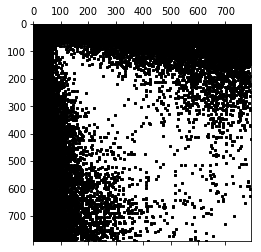

In [14]:
plt.spy(A, markersize=2, color='black');

In [15]:
val_data = test_data
val_labels = test_labels

# Classification

This section is devoted to the training and testing of different models in order to compare the results achieved with them.

We created a set of common parameters, which will be used for most of the models, such as e.g. non-linear ReLU function.
Furthermore, we trained 7 different neural network models for our input and output.

**The initial model configurations were taken from the previously referenced paper [Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering](https://arxiv.org/abs/1606.09375) however, they are optimized for our specific dataset** 

Model 1: 
    Network is composed of input, zero hidden layers and one output layer with a softmax function.

Model 2:
    Network is composed of input, one hidden layer and one output layer with a softmax function.

Model 3:
    Network is composed of input, two hidden layers and one output layer with a softmax function.

Model 4:
    Network is composed of input, one convolutional layer with Fourier filter and one output layer with softmax function.

Model 5:
    Network is composed of input, one convolutional layer with spline filter and one output layer with a softmax function.

Model 6:
    Network is composed of input, one convolutional layer with Chebyshev polynomial filter and one output layer with a softmax function.

Model 7:
    Network is composed of input, one convolutional layer with Chebyshev polynomial filter, one hidden layer and one output layer with a softmax function.

In [16]:
common = {}
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [17]:
name = 'softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 1e3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 793
  layer 1: logits (softmax)
    representation: M_1 = 18
    weights: M_0 * M_1 = 793 * 18 = 14274
    biases: M_1 = 18
step 400 / 729 (epoch 43.86 / 80):
  learning_rate = 1.10e+02, loss_average = 1.01e+00
  validation accuracy: 39.97 (237 / 593), f1 (weighted): 38.37, loss: 4.25e+01
  time: 2s (wall 2s)


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 729 / 729 (epoch 79.93 / 80):
  learning_rate = 1.74e+01, loss_average = 1.84e-01
  validation accuracy: 39.12 (232 / 593), f1 (weighted): 37.95, loss: 4.25e+01
  time: 3s (wall 2s)
validation accuracy: peak = 39.97, mean = 39.54
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
train accuracy: 98.36 (897 / 912), f1 (weighted): 98.35, loss: 2.77e+00
time: 0s (wall 0s)
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
test  accuracy: 39.12 (232 / 593), f1 (weighted): 37.95, loss: 4.25e+01
time: 0s (wall 0s)


In [18]:
name = 'fc_softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [4500, C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 793
  layer 1: fc1
    representation: M_1 = 4500
    weights: M_0 * M_1 = 793 * 4500 = 3568500
    biases: M_1 = 4500
  layer 2: logits (softmax)
    representation: M_2 = 18
    weights: M_1 * M_2 = 4500 * 18 = 81000
    biases: M_2 = 18
step 400 / 729 (epoch 43.86 / 80):
  learning_rate = 1.10e-02, loss_average = 1.20e+00
  validation accuracy: 43.00 (255 / 593), f1 (weighted): 37.29, loss: 1.85e+00
  time: 152s (wall 24s)


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 729 / 729 (epoch 79.93 / 80):
  learning_rate = 1.74e-03, loss_average = 1.13e+00
  validation accuracy: 44.69 (265 / 593), f1 (weighted): 39.10, loss: 1.85e+00
  time: 275s (wall 43s)
validation accuracy: peak = 44.69, mean = 43.84
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
train accuracy: 69.96 (638 / 912), f1 (weighted): 67.14, loss: 1.28e+00
time: 1s (wall 0s)
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
test  accuracy: 44.69 (265 / 593), f1 (weighted): 39.10, loss: 1.85e+00
time: 1s (wall 0s)


In [23]:
name = 'fc_fc_softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [3500, 500, C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 793
  layer 1: fc1
    representation: M_1 = 3500
    weights: M_0 * M_1 = 793 * 3500 = 2775500
    biases: M_1 = 3500
  layer 2: fc2
    representation: M_2 = 500
    weights: M_1 * M_2 = 3500 * 500 = 1750000
    biases: M_2 = 500
  layer 3: logits (softmax)
    representation: M_3 = 18
    weights: M_2 * M_3 = 500 * 18 = 9000
    biases: M_3 = 18
step 400 / 729 (epoch 43.86 / 80):
  learning_rate = 1.10e-02, loss_average = 6.60e-01
  validation accuracy: 43.34 (257 / 593), f1 (weighted): 39.31, loss: 2.01e+00
  time: 178s (wall 27s)


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 729 / 729 (epoch 79.93 / 80):
  learning_rate = 1.74e-03, loss_average = 4.74e-01
  validation accuracy: 43.68 (259 / 593), f1 (weighted): 40.23, loss: 2.06e+00
  time: 326s (wall 50s)
validation accuracy: peak = 43.68, mean = 43.51
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
train accuracy: 91.45 (834 / 912), f1 (weighted): 90.83, loss: 6.49e-01
time: 2s (wall 0s)
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
test  accuracy: 43.68 (259 / 593), f1 (weighted): 40.23, loss: 2.06e+00
time: 1s (wall 0s)


In [25]:
name = 'fgconv_softmax'
params = common.copy()
params['filter']         = 'fourier'
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.001
params['decay_rate']     = 1
params['momentum']       = 0
params['F']              = [32] 
params['K']              = [L[0].shape[0]]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 793
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 793 * 32 / 1 = 25376
    weights: F_0 * F_1 * K_1 = 1 * 32 * 793 = 25376
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 18
    weights: M_1 * M_2 = 25376 * 18 = 456768
    biases: M_2 = 18
step 400 / 729 (epoch 43.86 / 80):
  learning_rate = 1.00e-03, loss_average = 2.32e+00


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 20.57 (122 / 593), f1 (weighted): 7.02, loss: 2.30e+00
  time: 653s (wall 95s)
step 729 / 729 (epoch 79.93 / 80):
  learning_rate = 1.00e-03, loss_average = 2.30e+00
  validation accuracy: 20.40 (121 / 593), f1 (weighted): 6.97, loss: 2.30e+00
  time: 1196s (wall 169s)
validation accuracy: peak = 20.57, mean = 20.49
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
train accuracy: 20.18 (184 / 912), f1 (weighted): 6.99, loss: 2.46e+00
time: 7s (wall 1s)
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
test  accuracy: 20.40 (121 / 593), f1 (weighted): 6.97, loss: 2.30e+00
time: 4s (wall 1s)


In [26]:
name = 'sgconv_softmax'
params = common.copy()
params['filter']         = 'spline'
params['regularization'] = 1e-3
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [32]
params['K']              = [5]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 793
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 793 * 32 / 1 = 25376
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 18
    weights: M_1 * M_2 = 25376 * 18 = 456768
    biases: M_2 = 18
step 400 / 729 (epoch 43.86 / 80):
  learning_rate = 9.58e-02, loss_average = 3.96e+00


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 20.57 (122 / 593), f1 (weighted): 7.02, loss: 3.96e+00
  time: 642s (wall 90s)
step 729 / 729 (epoch 79.93 / 80):
  learning_rate = 9.24e-02, loss_average = 3.86e+00
  validation accuracy: 20.57 (122 / 593), f1 (weighted): 7.02, loss: 3.86e+00
  time: 1186s (wall 165s)
validation accuracy: peak = 20.57, mean = 20.57
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
train accuracy: 20.18 (184 / 912), f1 (weighted): 6.77, loss: 4.15e+00
time: 7s (wall 1s)
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
test  accuracy: 20.57 (122 / 593), f1 (weighted): 7.02, loss: 3.86e+00
time: 4s (wall 1s)


In [27]:
name = 'cgconv_softmax'
params = common.copy()
params['regularization'] = 1e-3
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [32]
params['K']              = [5]
params['p']              = [1]
params['M']              = [C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 793
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 793 * 32 / 1 = 25376
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 18
    weights: M_1 * M_2 = 25376 * 18 = 456768
    biases: M_2 = 18
step 400 / 729 (epoch 43.86 / 80):
  learning_rate = 9.58e-02, loss_average = 3.97e+00
  validation accuracy: 18.55 (110 / 593), f1 (weighted): 5.81, loss: 3.97e+00
  time: 91s (wall 19s)


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 729 / 729 (epoch 79.93 / 80):
  learning_rate = 9.24e-02, loss_average = 3.87e+00
  validation accuracy: 18.55 (110 / 593), f1 (weighted): 5.81, loss: 3.88e+00
  time: 164s (wall 35s)
validation accuracy: peak = 18.55, mean = 18.55
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
train accuracy: 18.86 (172 / 912), f1 (weighted): 5.98, loss: 4.19e+00
time: 1s (wall 0s)
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
test  accuracy: 18.55 (110 / 593), f1 (weighted): 5.81, loss: 3.88e+00
time: 1s (wall 0s)


In [28]:
name = 'cgconv_fc_softmax'
params = common.copy()
params['regularization'] = 0
params['dropout']        = 1
params['learning_rate']  = 0.1
params['decay_rate']     = 0.999
params['momentum']       = 0
params['F']              = [5]
params['K']              = [15]
params['p']              = [1]
params['M']              = [100, C]
model_perf.test(models.cgcnn(L, **params), name, params,
                train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 793
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 793 * 5 / 1 = 3965
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 3965 * 100 = 396500
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 18
    weights: M_2 * M_3 = 100 * 18 = 1800
    biases: M_3 = 18
step 400 / 729 (epoch 43.86 / 80):
  learning_rate = 9.58e-02, loss_average = 2.33e+00


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 20.40 (121 / 593), f1 (weighted): 11.50, loss: 2.31e+00
  time: 93s (wall 22s)
step 729 / 729 (epoch 79.93 / 80):
  learning_rate = 9.24e-02, loss_average = 2.31e+00
  validation accuracy: 20.07 (119 / 593), f1 (weighted): 9.50, loss: 2.30e+00
  time: 173s (wall 42s)
validation accuracy: peak = 20.40, mean = 20.24
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
train accuracy: 18.31 (167 / 912), f1 (weighted): 7.56, loss: 2.47e+00
time: 2s (wall 1s)
INFO:tensorflow:Restoring parameters from C:\Users\Milena Filipovic\ntds_project\project\lib\..\checkpoints\model-729
test  accuracy: 20.07 (119 / 593), f1 (weighted): 9.50, loss: 2.30e+00
time: 1s (wall 0s)


  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
20.07 18.31    9.50  7.56   2.30e+00 2.47e+00    58   cgconv_fc_softmax
18.55 18.86    5.81  5.98   3.88e+00 4.19e+00    48   cgconv_softmax
43.68 91.45   40.23 90.83   2.06e+00 6.49e-01    70   fc_fc_softmax
44.69 69.96   39.10 67.14   1.85e+00 1.28e+00    60   fc_softmax
20.40 20.18    6.97  6.99   2.30e+00 2.46e+00   233   fgconv_softmax
20.57 20.18    7.02  6.77   3.86e+00 4.15e+00   227   sgconv_softmax
39.12 98.36   37.95 98.35   4.25e+01 2.77e+00     4   softmax


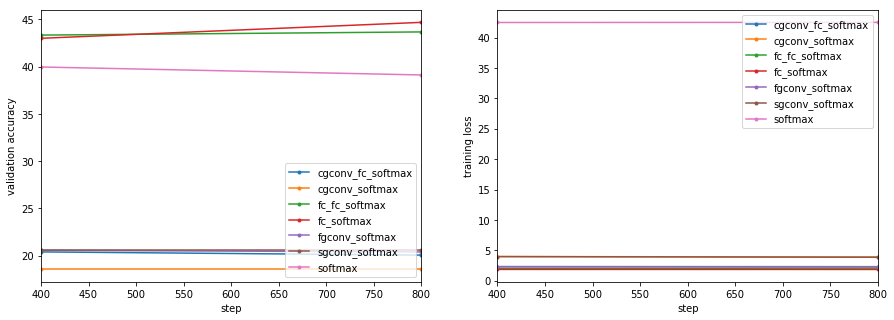

In [29]:
model_perf.show()


On the plot above we can observe the testing accuracy of the different models. From this, we can see that the best model for our data was the 'fc_softmax' model, with one hidden layer and one output layer with a softmax function. Although this was our best model, the maximum test accuracy achieved was 44.69%. This is considerably better than what we were able to accomplish with the spectral clustering methods, but not the result we were hoping for. 
However, it is again important to underline that we are classifying only by the first genre of each movie and that keywords used for movies with ['Action', 'Adventure'] genres, and those used for movies with ['Adventure', 'Action'] genres are generally very similar. We believe that this, coupled with the small set of words used in the embeddings graph contributed considerably to the poor performance of the models with convolutional layers.
The goal of this part of our project was to experiment with CNNs and to improve our accuracy score, by overcoming some of the difficulties faced in the previous steps.